In [1]:
from __future__ import annotations
from typing import Any

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

In [2]:
df = (pd
    .read_csv(
        'data/crosswriters_with_ents.csv', 
        encoding='utf-8', 
        usecols=['text', 'title', 'author', 'author_gender', 'reader_age_group']
    )
    .astype({
        'author': 'category', 
        'title': 'category', 
        'author_gender': 'category', 
        'reader_age_group': 'category'
    })
)
df.sample(10)

,text,author,title,author_gender,reader_age_group
4536,prague. and for god’s sake don’t let the germa...,Philip Pullman,The Tin Princess,M,child
4702,and killers were not strangers in masks who re...,J.K. Rowling,Career of Evil,F,adult
2511,standing around the grave. the women wore dark...,Neil Gaiman,Anansi Boys,M,adult
5261,"hampers of sweets, quidditch tickets and visit...",J.K. Rowling,Harry Potter and the Half-Blood Prince,F,child
4411,"initiates devoted to the understanding, the pr...",Philip Pullman,The Tiger in the Well,M,child
295,"so strange and so lovely, coming through the d...",David Almond,Jackdaw Summer,M,child
4958,and get back in her good books.’ ‘all’s fair i...,J.K. Rowling,Harry Potter and the Deathly Hallows,F,child
1144,"backs to us, and they were staring at a cottag...",Anne Fine,Eating Things on Sticks,F,child
3009,one end of the rope about his waist and edged ...,Neil Gaiman,The Truth is a Cave in the Black Mountains,M,adult
1820,argued. ‘i’m well over forty myself and—’ she ...,Anne Fine,The Book of the Banshee,F,child


## SVM: Child vs Adult 

### All authors

In [3]:
print("Before:", df['reader_age_group'].value_counts(), sep="\n", end="\n\n")

enc = LabelEncoder()
enc.fit(df['reader_age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['reader_age_group'] = enc.transform(df['reader_age_group'])

print("After:", df['reader_age_group'].value_counts(), sep="\n")
encoded_labels

Before:
child    4412
adult    2457
Name: reader_age_group, dtype: int64

After:
1    4412
0    2457
Name: reader_age_group, dtype: int64


{'adult': 0, 'child': 1}

In [4]:
X = df['text']
y = df['reader_age_group']
groups = df['text']

# With LOGO
# logo_cv = LeaveOneGroupOut()
# train_idx, test_idx = next(logo_cv.split(X, y, groups=groups))
# X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

# With GSS
gss_cv = GroupShuffleSplit(n_splits=10, random_state=97)
train_idx, test_idx = next(gss_cv.split(X, y, groups))
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
X_train.shape, X_test.shape

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97, stratify=y)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5495,), (1374,))

In [5]:
# Just to be sure no characters are picked up from dialogue text,
# we add them as stopwords by passing them to the built-in list, 
# according to the source code (the link is commit-specific):
# https://github.com/scikit-learn/scikit-learn/blob/5fd66bc55f03740f395971abf1189b11594252b1/sklearn/feature_extraction/text.py#L194
 
with open('entities.txt', 'r', encoding='utf-8') as f:
    entities = f.read().splitlines()
stop_words = ENGLISH_STOP_WORDS.union(entities)

In [6]:
vect = TfidfVectorizer(stop_words=stop_words)
svm  = LinearSVC()
pipe = make_pipeline(vect, svm)

pprint(pipe.get_params(), sort_dicts=False)

{'memory': None,
 'steps': [('tfidfvectorizer',
            TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                      'across', 'action', 'ada', 'africa',
                                      'after', 'afterwards', 'again', 'against',
                                      'agents', 'akil', 'al', 'alan',
                                      'alderman', 'alex', 'alice', 'alicia',
                                      'alisa', 'all', 'alley', 'allie', 'ally',
                                      'almost', 'alone', 'along', 'already', ...}))),
           ('linearsvc', LinearSVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                      'across', 'action', 'ada', 'africa',
                                      'after', 'afterwards', 'again', 'against',
                                      'agents', 'akil', 'al', 'alan',
          

In [7]:
param_grid = {
    'linearsvc__class_weight': ['balanced', None],
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__max_df': [0.25],
    'tfidfvectorizer__lowercase': [False]  # already lowercased
}

In [8]:
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=gss_cv,
    scoring=('f1_macro', 'accuracy'),
    n_jobs=-1,  # for some weird reason, setting `n_jobs` != 1 causes `verbose` not to work...
    refit='f1_macro',
    verbose=5
)
gs.fit(X_train, y_train, groups=groups[train_idx])

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=GroupShuffleSplit(n_splits=10, random_state=97, test_size=None,
         train_size=None),
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'acacia',
                                                                              'ace',
                                                                              'across',
                                                                              'action',
                                                                              'ada',
                                                                              'africa',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'agents',
                                                                              'akil',
                                                                              'al',
                                                                              'alan',
                                                                              'alderman',
                                                                              'alex',
                                                                              'alice',
                                                                              'alicia',
                                                                              'alisa',
                                                                              'all',
                                                                              'alley',
                                                                              'allie',
                                                                              'ally',
                                                                              'almost',
                                                                              'alone',
                                                                              'along',
                                                                              'already', ...}))),
                                       ('linearsvc', LinearSVC())]),
             n_jobs=-1,
             param_grid={'linearsvc__class_weight': ['balanced', None],
                         'tfidfvectorizer__lowercase': [False],
                         'tfidfvectorizer__max_df': [0.25],
                         'tfidfvectorizer__ngram_range': [(1, 1), (2, 2),
                                                          (3, 3)]},
             refit='f1_macro', scoring=('f1_macro', 'accuracy'), verbose=5)

In [9]:
# Problem: `GridSearchCV.best_estimator_.get_params()` doesn't return *just* the parameters that changed.
# As a result, it's hard to know which one(s) have overriden the defaults.
# So, I made a function that returns the parameters that changed - inspired by `set.difference()`.
# I also made another one that looks at the keys and returns the ones that their values are different.

def dict_difference_values(d1: dict, d2: dict) -> dict:
    return {k: v for k, v in d2.items() if v != d1[k]}

def dict_difference_keys(d1: dict, d2: dict) -> dict:
    return {k: v for k, v in d2.items() if k not in d1}

In [10]:
print(f"Best score: {gs.best_score_:.3f}", end="\n\n")

default_params = pipe.get_params()
best_est_params = gs.best_estimator_.get_params()
dict_difference_values(default_params, best_est_params)

Best score: 0.974



{'steps': [('tfidfvectorizer',
   TfidfVectorizer(lowercase=False, max_df=0.25,
                   stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                         'across', 'action', 'ada', 'africa',
                                         'after', 'afterwards', 'again', 'against',
                                         'agents', 'akil', 'al', 'alan',
                                         'alderman', 'alex', 'alice', 'alicia',
                                         'alisa', 'all', 'alley', 'allie', 'ally',
                                         'almost', 'alone', 'along', 'already', ...}))),
  ('linearsvc', LinearSVC(class_weight='balanced'))],
 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_df=0.25,
                 stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                       'across', 'action', 'ada', 'africa',
                                       'after', 'afterwards', 'again', 'again

In [11]:
y_pred = gs.predict(X_test)

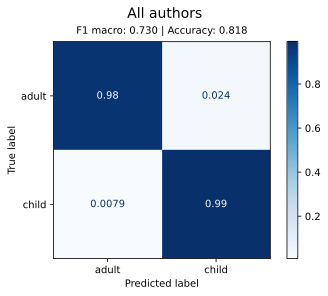

In [12]:
palette = sns.color_palette('gist_stern_r', as_cmap=True)
classes = [label for label in encoded_labels]
title = "All authors"

# Subtitle
scorers = []
for scoring, _ in gs.scorer_.items():
    score = gs.cv_results_[f'mean_test_{scoring}'].mean()
    scoring = scoring.replace('_', ' ').capitalize()
    scorers.append(f'{scoring}: {score:.3f}')

subtitle = " | ".join(scorers)

disp = ConfusionMatrixDisplay.from_estimator(
    gs,
    X_test,
    y_test,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize='true',
)

plt.suptitle(title, y=1, fontsize=14)
disp.ax_.set_title(subtitle, fontsize=10, pad=8)
disp.ax_.tick_params(axis='x');

In [13]:
features_names = gs.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names_out()
clf = gs.best_estimator_.named_steps['linearsvc']

In [14]:
def plot_coefficients(
    classifier: Any, 
    feature_names: Any,
    *, 
    who: str = 'all', 
    n_features: int = 20
) -> None:

    coef = classifier.coef_.ravel()
    top_pos_coefficients = np.argsort(coef)[-n_features:]
    top_neg_coefficients = np.argsort(coef)[:n_features]
    top_coefficients = np.hstack([top_neg_coefficients, top_pos_coefficients])

    feature_names = np.array(feature_names)

    # Plot
    plt.figure(figsize=(n_features * 0.75, n_features * 0.25))

    # Appearance
    colors = ['#a52040' if c < 0 else '#404080' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_features), coef[top_coefficients], color=colors, zorder=2)
    plt.suptitle(f"Coefficients ({classifier.__class__.__name__})", y=.975, fontsize=14)

    # - Subtitle (main title is already set as `suptitle`)
    if who == 'all':
        title = "All authors"
    else:
        title = who.title()
    plt.title(f"{title} (top {n_features * 2} features)", x=.485, pad=8)

    # - Axis labels
    _, _, ymin, ymax = plt.axis()
    step = 0.5
    # Round to nearest 0.5:
    ymin = round(ymin * 2) / 2 - step
    ymax = round(ymax * 2) / 2 + step

    plt.yticks(np.arange(ymin, ymax, step))
    plt.xticks(np.arange(0, 2 * n_features), feature_names[top_coefficients], ha='right', rotation=60)
    plt.grid(axis='both', linestyle='--', alpha=.25, zorder=1)

    # Custom legend 
    adult_patch = mpatches.Patch(color='#a52040', label='Adult')
    child_patch = mpatches.Patch(color='#404080', label='Child')
    plt.legend(handles=[adult_patch, child_patch], loc='lower right')

    plt.show()

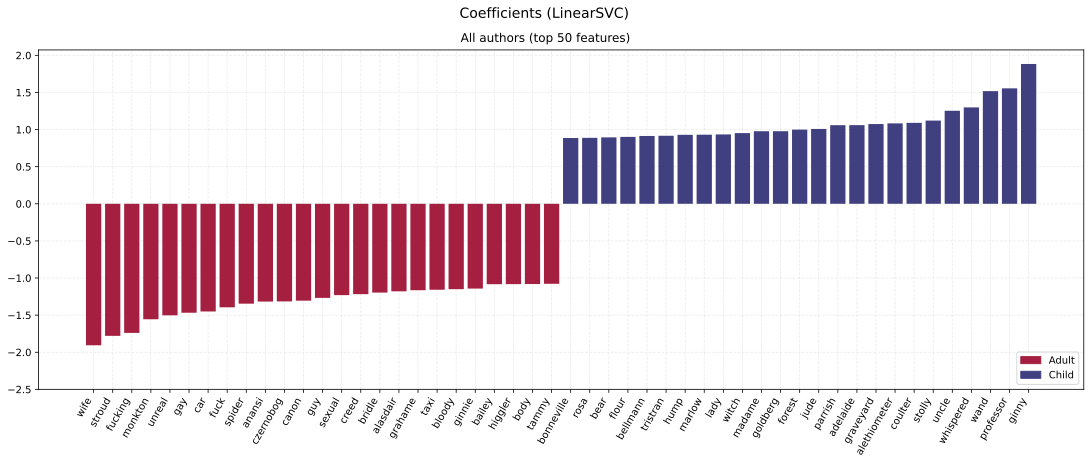

In [15]:
plot_coefficients(clf, features_names, who='all', n_features=25)

## Individual authors

=========================================== David Almond ===========================================

X_train: (620,)	 X_test: (155,)
y_train: (620,)	 y_test: (155,)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best score: 0.946

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.25, max_features=5000,
                stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                      'across', 'action', 'ada', 'africa',
                                      'after', 'afterwards', 'again', 'against',
                                      'agents', 'akil', 'al', 'alan',
                                      'alderman', 'alex', 'alice', 'alicia',
                                      'alisa', 'all', 'alley', 'allie', 'ally',
                                      'almost', 'alone', 'along', 'already', ...}))), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': Tfidf

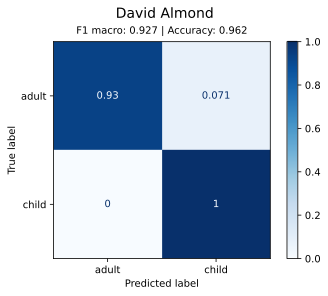

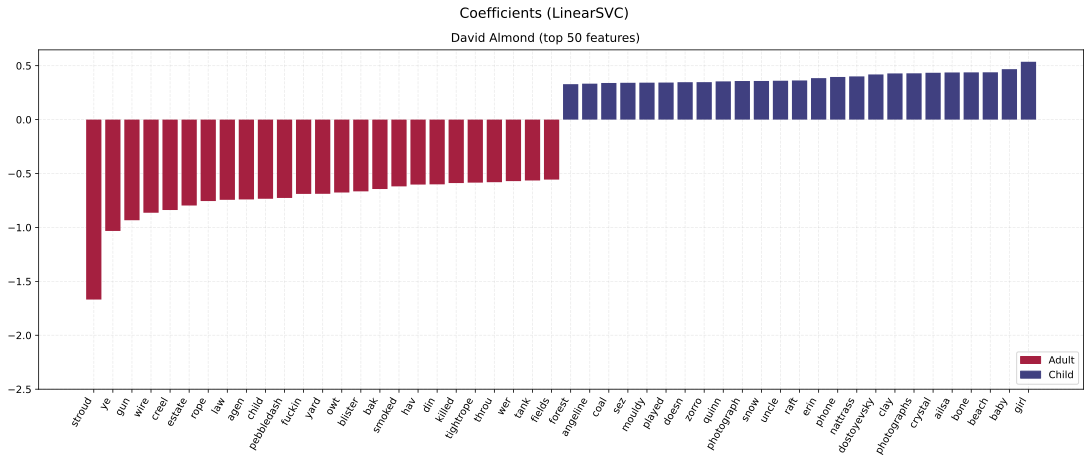

============================================ Anne Fine =============================================

X_train: (1237,)	 X_test: (310,)
y_train: (1237,)	 y_test: (310,)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best score: 0.981

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.25, max_features=5000,
                stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                      'across', 'action', 'ada', 'africa',
                                      'after', 'afterwards', 'again', 'against',
                                      'agents', 'akil', 'al', 'alan',
                                      'alderman', 'alex', 'alice', 'alicia',
                                      'alisa', 'all', 'alley', 'allie', 'ally',
                                      'almost', 'alone', 'along', 'already', ...}))), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': Tfi

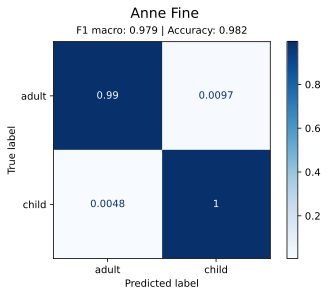

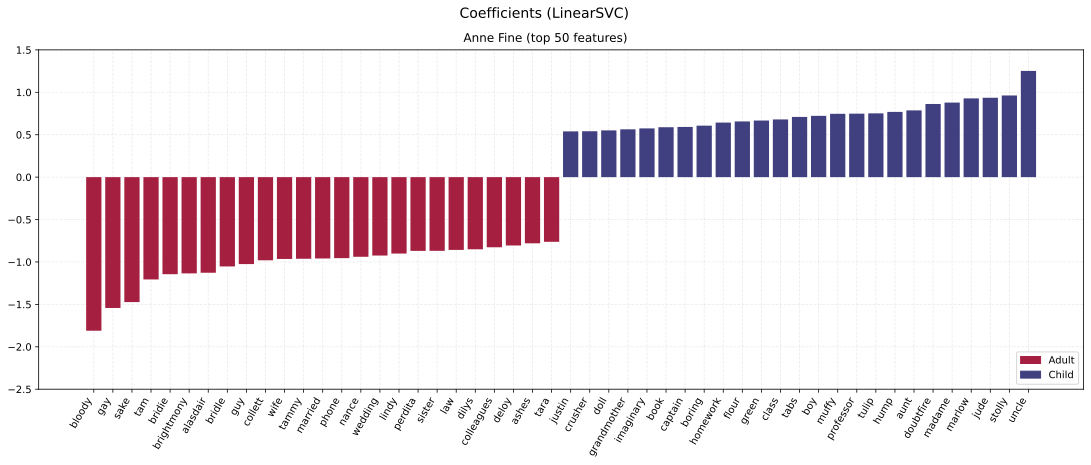

=========================================== Neil Gaiman ============================================

X_train: (553,)	 X_test: (139,)
y_train: (553,)	 y_test: (139,)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best score: 0.971

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.25, max_features=5000,
                stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                      'across', 'action', 'ada', 'africa',
                                      'after', 'afterwards', 'again', 'against',
                                      'agents', 'akil', 'al', 'alan',
                                      'alderman', 'alex', 'alice', 'alicia',
                                      'alisa', 'all', 'alley', 'allie', 'ally',
                                      'almost', 'alone', 'along', 'already', ...}))), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': Tfidf

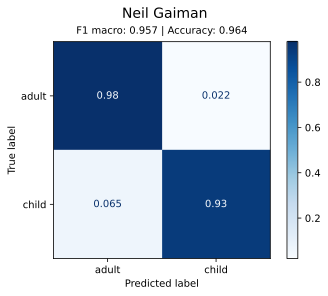

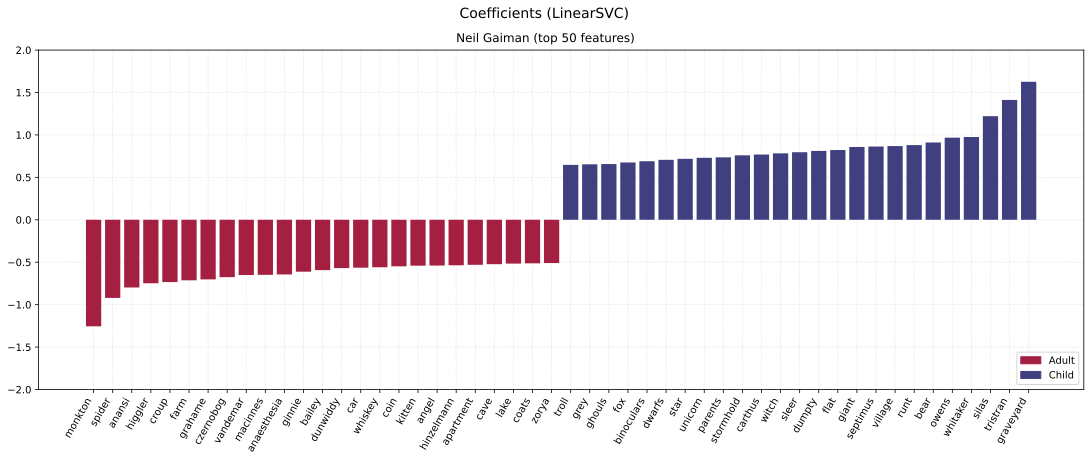

========================================== Philip Pullman ==========================================

X_train: (1280,)	 X_test: (320,)
y_train: (1280,)	 y_test: (320,)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best score: 0.982

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.25, max_features=5000,
                stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                      'across', 'action', 'ada', 'africa',
                                      'after', 'afterwards', 'again', 'against',
                                      'agents', 'akil', 'al', 'alan',
                                      'alderman', 'alex', 'alice', 'alicia',
                                      'alisa', 'all', 'alley', 'allie', 'ally',
                                      'almost', 'alone', 'along', 'already', ...}))), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': Tfi

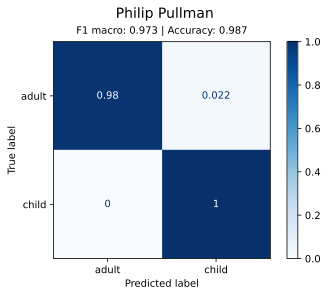

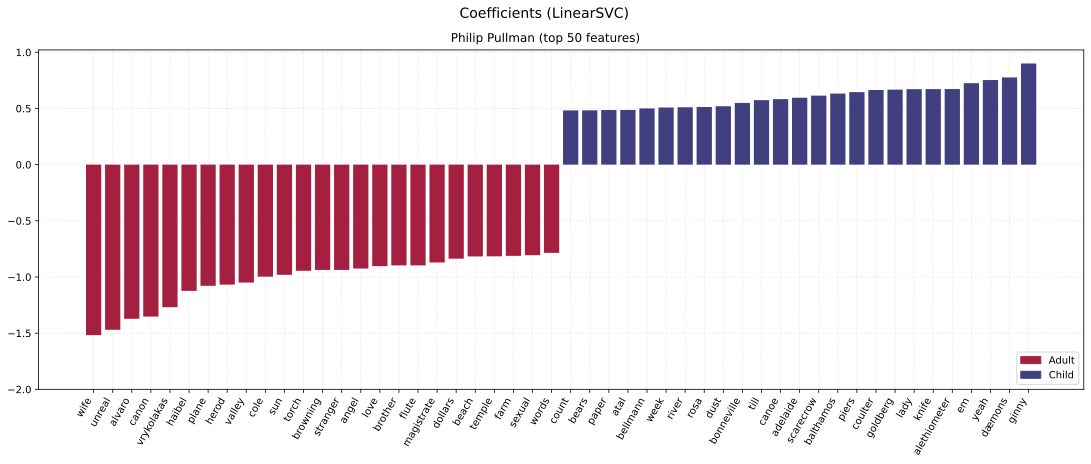

=========================================== J.K. Rowling ===========================================

X_train: (1804,)	 X_test: (451,)
y_train: (1804,)	 y_test: (451,)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best score: 0.999

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.25, max_features=5000,
                stop_words=frozenset({'a', 'about', 'above', 'acacia', 'ace',
                                      'across', 'action', 'ada', 'africa',
                                      'after', 'afterwards', 'again', 'against',
                                      'agents', 'akil', 'al', 'alan',
                                      'alderman', 'alex', 'alice', 'alicia',
                                      'alisa', 'all', 'alley', 'allie', 'ally',
                                      'almost', 'alone', 'along', 'already', ...}))), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': Tfi

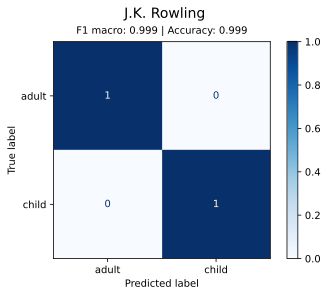

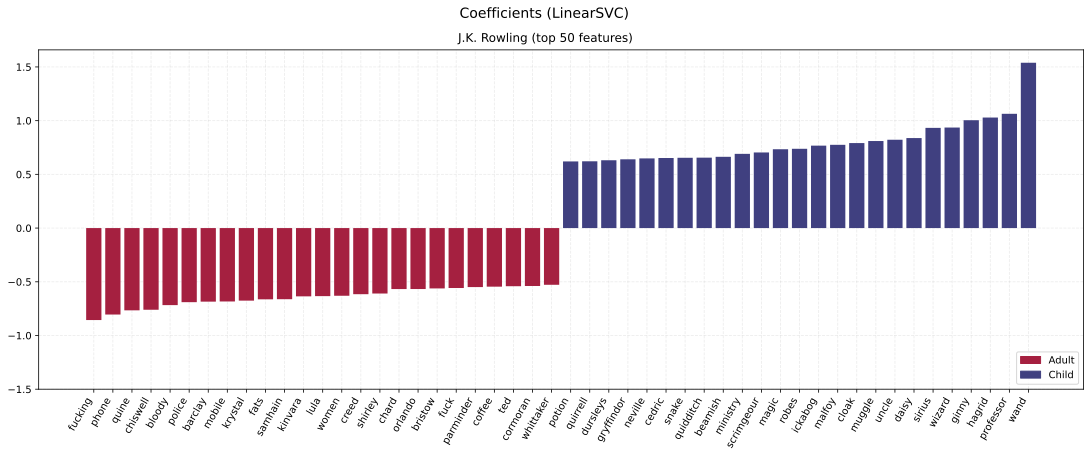

In [15]:
for author in df['author'].unique():

    # Format author name in output
    print(f' {author} '.center(100, "="), end="\n\n")

    # Get subset for `author` and then train/test split
    df_author = df[df['author'] == author]
    author_snake = author.replace(' ', '_').replace('.', '').lower()
    df_author.to_csv(f'data/author_dfs_no_ents/{author_snake}.csv', index=False, encoding='utf-8')

    X = df_author['text']
    y = df_author['reader_age_group']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97, stratify=y)
    print(
        f"X_train: {X_train.shape}\t X_test: {X_test.shape}",
        f"y_train: {y_train.shape}\t y_test: {y_test.shape}",
        sep="\n", end="\n\n"
    )

    # Set up pipeline and grid search
    vect = TfidfVectorizer(max_features=5000, stop_words=stop_words)
    svm  = LinearSVC()
    pipe = make_pipeline(vect, svm)

    param_grid = {
        'linearsvc__class_weight': ['balanced', None],
        'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidfvectorizer__max_df': [0.25],  # try to avoid overfitting
        'tfidfvectorizer__lowercase': [False]  # already lowercased
    }

    gs = GridSearchCV(
        pipe, 
        param_grid, 
        cv=10,
        scoring=('f1_macro', 'accuracy'), 
        n_jobs=-1,  # Again `verbose` doesn't work with `n_jobs` != 1
        refit='f1_macro',
        verbose=5
    )

    gs.fit(X_train, y_train)

    print(f"Best score: {gs.best_score_:.3f}", end="\n\n")
    pipe_params = pipe.get_params()
    best_params = gs.best_estimator_.get_params()
    print(
        "Default params were overriden by:",
        dict_difference_values(pipe_params, best_params), 
        sep="\n", end="\n\n"
    )

    y_pred = gs.predict(X_test)

    # Plot confusion matrix
    palette = sns.color_palette('gist_stern_r', as_cmap=True)
    classes = [label for label in encoded_labels]
    title = f"{author}".title()

    disp = ConfusionMatrixDisplay.from_estimator(
        gs,
        X_test,
        y_test,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize='true'
    )

    plt.suptitle(title, y=1, fontsize=14)

    # Subtitle
    scorers = []
    for scoring, _ in gs.scorer_.items():
        score = gs.cv_results_[f'mean_test_{scoring}'].mean()
        scoring = scoring.replace('_', ' ').capitalize()
        scorers.append(f'{scoring}: {score:.3f}')

    subtitle = " | ".join(scorers)

    disp.ax_.set_title(subtitle, fontsize=10, pad=8)
    disp.ax_.tick_params(axis='x');

    # Plot coefficients
    clf = gs.best_estimator_.named_steps['linearsvc']
    features_names = gs.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names_out()
    plot_coefficients(clf, features_names, who=author, n_features=25)